In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from itertools import chain
import seaborn as sns

In [124]:
f_name_arabic = './out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_position_fewshot_last_counterfactual.feather'
#f_name_arabic = '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_further_templates.feather'
data_arabic = pd.read_feather(f_name_arabic)
split_string = f_name_arabic.split("intervention_1_")
f_name_words = split_string[0] + "intervention_1_words" + split_string[1][6:]
data_words = pd.read_feather(f_name_words)


In [125]:
data_arabic['IE'] = 0.5 * ((data_arabic['res_base_prob'] - data_arabic['res_base_alt_prob']) / data_arabic['res_base_alt_prob'] + 
                    (data_arabic['res_alt_alt_prob'] - data_arabic['res_alt_prob']) / data_arabic['res_alt_prob'])

data_arabic['IE_logits'] = 0.5 * ((data_arabic['res_base_logit'] - data_arabic['res_base_alt_logit']) / data_arabic['res_base_alt_logit'] +
                            (data_arabic['res_alt_alt_logit'] - data_arabic['res_alt_logit']) / data_arabic['res_alt_logit'])

data_arabic['patching_effect'] = (data_arabic['res_base_logit'] - data_arabic['res_alt_logit']) - (data_arabic['res_base_alt_logit'] - data_arabic['res_alt_alt_logit'])
data_arabic['patching_effect_normalized'] = ((data_arabic['res_base_logit'] - data_arabic['res_alt_logit']) - (data_arabic['res_base_alt_logit'] - data_arabic['res_alt_alt_logit'])) / (data_arabic['res_base_base_logit'] - data_arabic['res_alt_base_logit'])
data_arabic['patching_effect_prob'] = (data_arabic['res_base_prob'] - data_arabic['res_alt_prob']) - (data_arabic['res_base_alt_prob'] - data_arabic['res_alt_alt_prob'])
data_arabic['patching_effect_prob_normalized'] = ((data_arabic['res_base_prob'] - data_arabic['res_alt_prob']) - (data_arabic['res_base_alt_prob'] - data_arabic['res_alt_alt_prob'])) / (data_arabic['res_base_base_prob'] - data_arabic['res_alt_base_prob'])
data_arabic['representation'] = 'arabic'
data_words['IE'] = 0.5 * ((data_words['res_base_prob'] - data_words['res_base_alt_prob']) / data_words['res_base_alt_prob'] + 
                    (data_words['res_alt_alt_prob'] - data_words['res_alt_prob']) / data_words['res_alt_prob'])

data_words['IE_logits'] = 0.5 * ((data_words['res_base_logit'] - data_words['res_base_alt_logit']) / data_words['res_base_alt_logit'] +
                            (data_words['res_alt_alt_logit'] - data_words['res_alt_logit']) / data_words['res_alt_logit'])

data_words['patching_effect'] = (data_words['res_base_logit'] - data_words['res_alt_logit']) - (data_words['res_base_alt_logit'] - data_words['res_alt_alt_logit'])
data_words['patching_effect_normalized'] = ((data_words['res_base_logit'] - data_words['res_alt_logit']) - (data_words['res_base_alt_logit'] - data_words['res_alt_alt_logit'])) / (data_words['res_base_base_logit'] - data_words['res_alt_base_logit'])
data_words['patching_effect_prob'] = (data_words['res_base_prob'] - data_words['res_alt_prob']) - (data_words['res_base_alt_prob'] - data_words['res_alt_alt_prob'])
data_words['patching_effect_prob_normalized'] = ((data_words['res_base_prob'] - data_words['res_alt_prob']) - (data_words['res_base_alt_prob'] - data_words['res_alt_alt_prob'])) / (data_words['res_base_base_prob'] - data_words['res_alt_base_prob'])
data_words['representation'] = 'words'

In [126]:
data = pd.concat([data_arabic, data_words], ignore_index=True)
data

,example,template_id,n_vars,base_string,alt_string,few_shots,equation,res_base,res_alt,res_base_base_prob,...,res_alt_logit,hooked_pred_base,hooked_pred_alt,IE,IE_logits,patching_effect,patching_effect_normalized,patching_effect_prob,patching_effect_prob_normalized,representation
0,0,-,2,2 + 6 + 6 =,2 + 6 + 6 =,10 + 2 + 3 = fifteen.,({x}+{y}+{z}),14,10,0.149806,...,13.335938,14,14,1.228030,0.060483,1.601562,0.452539,0.329882,2.267919,arabic
1,0,-,2,2 + 6 + 6 =,2 + 6 + 6 =,None,({x}+{y}+{z}),14,10,0.149806,...,14.273438,10,10,-0.064084,-0.004490,-0.132812,-0.037528,-0.034555,-0.237564,arabic
2,0,-,2,2 + 6 + 6 =,2 + 6 + 6 =,None,({x}+{y}+{z}),14,10,0.149806,...,14.164062,10,10,-0.167599,-0.013744,-0.367188,-0.103753,-0.081352,-0.559287,arabic
3,0,-,2,2 + 6 + 6 =,2 + 6 + 6 =,None,({x}+{y}+{z}),14,10,0.149806,...,13.937500,10,10,0.068740,0.004731,0.132812,0.037528,0.031417,0.215987,arabic
4,0,-,2,2 + 6 + 6 =,2 + 6 + 6 =,None,({x}+{y}+{z}),14,10,0.149806,...,14.031250,10,10,0.007865,0.000464,0.015625,0.004415,0.004751,0.032660,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,1,-,2,six + two + three =,six + two + three =,None,({x}+{y}+{z}),eleven,seven,0.086010,...,12.390625,seven,seven,-0.019340,-0.001693,-0.039062,-0.012887,-0.002849,-0.034800,words
1328,1,-,2,six + two + three =,six + two + three =,None,({x}+{y}+{z}),eleven,seven,0.086010,...,12.375000,seven,seven,-0.019223,-0.001810,-0.039062,-0.012887,-0.001234,-0.015070,words
1329,1,-,2,six + two + three =,six + two + three =,None,({x}+{y}+{z}),eleven,seven,0.086010,...,12.375000,seven,seven,-0.019254,-0.001810,-0.039062,-0.012887,-0.001490,-0.018204,words
1330,1,-,2,six + two + three =,six + two + three =,None,({x}+{y}+{z}),eleven,seven,0.086010,...,12.382812,seven,seven,-0.019303,-0.001752,-0.039062,-0.012887,-0.002021,-0.024686,words


In [127]:
print(np.mean(data_arabic.pred_base == data_arabic.res_base))
print(np.mean(data_arabic.pred_alt == data_arabic.res_base))

0.5
0.0


In [128]:
first_few_shots = data.groupby(['operation', 'representation'])['few_shots'].first()
first_few_shots = first_few_shots.reset_index()
first_few_shots['few_shot_string'] = first_few_shots['few_shots'].apply(lambda x: x.split())
def split_on_special_characters(lst):
    # Define the regular expression pattern
    pattern = r'(\w+)([!,:?])'
    # Initialize an empty list to store the results
    result = []
    for item in lst:
        # Find all matches in the string
        matches = re.findall(pattern, item)
        if matches:
            # If matches are found, extend the result list with the split elements
            for match in matches:
                result.extend(match)
        else:
            # If no matches, just append the item as it is
            result.append(item)
    return result
# Apply the function to the 'few_shot_string' column
first_few_shots['few_shot_string'] = first_few_shots['few_shot_string'].apply(split_on_special_characters)
unique_examples_by_operation = data.groupby('operation')['example'].nunique()
first_few_shots['n_instances'] = first_few_shots['operation'].map(unique_examples_by_operation)

if 'position_task' in f_name_arabic:
    operation_position_operands = {' *  * ': [14,16,18],
                                      ' --': [14,16,18],
                                      '* * ': [14,16,18],
                                      '**': [8,10,12],
                                      '+ + ': [14, 16, 18],
                                      '++': [8, 10, 12],
                                      '-*': [17,19,22]}
elif 'reversed_fewshot' in f_name_arabic:
    operation_position_operands = {' *  * ': [2,4,6],
                                      ' --': [5,7,9],
                                      '* * ': [5,7,9],
                                      '**': [2, 4,6],
                                      '+ + ': [5,7,9],
                                      '++': [2, 4, 6],
                                      '-*': [6,8,11]}
else:
    operation_position_operands = {' *  * ': [3, 5, 7],
                               ' --': [3, 5, 7],
                               '* * ': [3, 5, 7],
                               '**': [0, 2, 4],
                               '+ + ': [3, 5, 7],
                               '++': [0, 2, 4],
                               '-*': [4, 6, 9]}

if 'position_task' in f_name_arabic:
    operation_position_result = {' *  * ': 19,
                                ' --': 19,
                                '* * ': 19,
                                '**': 13,
                                '+ + ': 19,
                                '++': 13,
                                '-*': 23}
elif 'reversed_fewshot' in f_name_arabic:
    operation_position_result = {' *  * ': 0,
                                ' --': 0,
                                '* * ': 0,
                                '**': 0,
                                '+ + ': 0,
                                '++': 0,
                                '-*': 0}
else:
    operation_position_result = {' *  * ': 9,
                                    ' --': 9,
                                    '* * ': 9,
                                    '**': 6,
                                    '+ + ': 9,
                                    '++': 6,
                                    '-*': 11}


data['position_operands'] = data['operation'].map(operation_position_operands)
data['position_result'] = data['operation'].map(operation_position_result)
data['position_first_operand'] = data['position_operands'].apply(lambda x: x[0])
data['position_second_operand'] = data['position_operands'].apply(lambda x: x[1])
data['position_third_operand'] = data['position_operands'].apply(lambda x: x[2])
data['position_first_operator'] = data['position_first_operand'] + 1
data['position_second_operator'] = data['position_third_operand'] - 1
data['position_equality_sign'] = data['position_result'] + 1 if "reversed" in f_name_arabic else data['position_result'] - 1 
print(unique_examples_by_operation)




operation
++    2
Name: example, dtype: int64


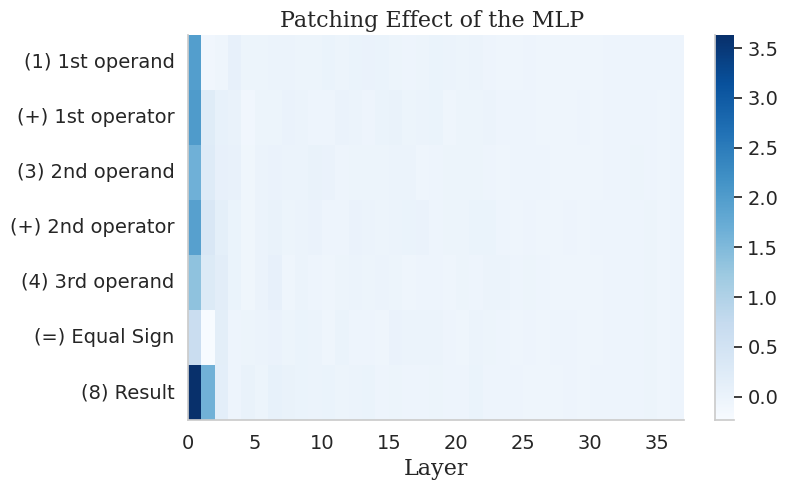

In [129]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
is_attention = "attention_layer_output" in f_name_arabic
is_mixed = "mixed" in f_name_arabic
if is_attention:
    intervention_loc = "Attention"
    vmax = None
else:
    if is_mixed:
        intervention_loc = "embedding layer's MLP and Attention"
        vmax = None
    elif 'reversed_fewshot' in f_name_arabic:
        vmax = None
        intervention_loc = "Attention" if "attention" in f_name_arabic else "the MLP"
    else:
        if f_name_arabic == '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_further_templates.feather':
            vmax = None
            intervention_loc = "the MLP"
        elif f_name_arabic == '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_counterfactual_inconsistent_symbol_operands_further_templates.feather':
            vmax = None
        else:
            vmax = None #2.6
            intervention_loc = "the MLP"
# 7 x layer matrix
matrix = np.empty((7, len(data['layer'].unique())))
position_names = ['position_first_operand', 'position_first_operator', 'position_second_operand', 'position_second_operator', 'position_third_operand', 'position_equality_sign', 'position_result']
if 'reversed_fewshot' in f_name_arabic:
    position_names = ['position_result', 'position_equality_sign', 'position_first_operand', 'position_first_operator', 'position_second_operand', 'position_second_operator', 'position_third_operand']
for i, op in enumerate(position_names):
    for j, layer in enumerate(data['layer'].unique()):
        subset_df = data[data[op] == data['position']]
        subset_df = subset_df[subset_df['layer'] == layer]
        matrix[i, j] = subset_df['patching_effect'].mean()
        #print(subset_df['patching_effect'].mean())
        
# Create a dataframe from the matrix
idx = ['(1) 1st operand', '(+) 1st operator', '(3) 2nd operand', '(+) 2nd operator', '(4) 3rd operand', '(=) Equal Sign', '(8) Result']
if 'reversed_fewshot' in f_name_arabic:
    idx = ['(8) Result', '(=) Equal Sign', '(1) 1st operand', '(+) 1st operator', '(3) 2nd operand', '(+) 2nd operator', '(4) 3rd operand']
df = pd.DataFrame(matrix, index=idx, columns=data['layer'].unique())

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.heatmap(df, cmap="Blues", annot=False, fmt=".1f", cbar=True, vmax=vmax)
# set x-axis ticks to the range of unique layers
ax.set_xticks(range(data.layer.max()))

# set x-axis labels to the range of unique layers
ax.set_xticklabels(range(data.layer.max()), fontsize=14, rotation=0)
plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

# Y-axis adjustments: Make labels horizontal and remove the y-axis title
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
plt.ylabel('')  # Remove y-axis title

# Title and other adjustments
plt.title(f'Patching Effect of {intervention_loc} ', fontsize=16, fontname='DeJavu Serif')

# Adjust color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
#cbar.set_label(label='', size=12, weight='bold', fontname='DeJavu Serif')

# Remove chart junk
sns.despine()

#plt.savefig("patching_effect_mlp.png", format='png', bbox_inches='tight')
plt.show()


In [16]:
matrix

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, n

In [128]:
matrix[:, 0]

array([0.32500436, 0.85378841, 0.80350908, 0.80927025, 0.74519902,
       0.5900838 , 0.15520251])

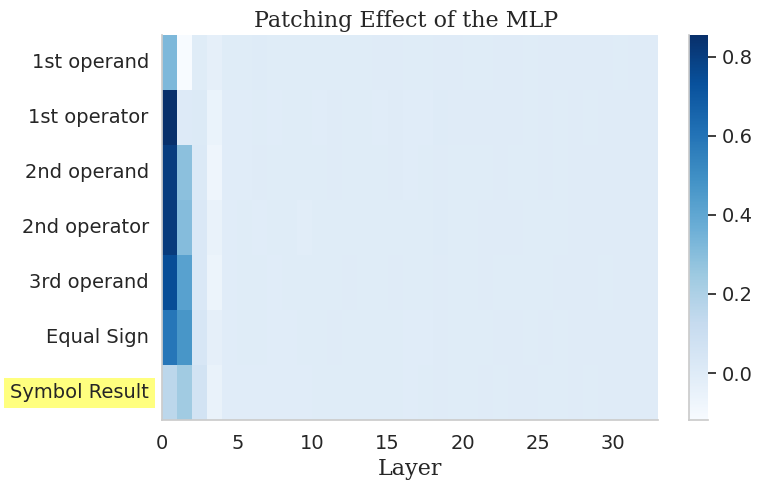

In [129]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
is_attention = "attention_layer_output" in f_name_arabic
is_mixed = "mixed" in f_name_arabic
if is_attention:
    intervention_loc = "Attention"
    vmax = None
else:
    if is_mixed:
        intervention_loc = "MLP embedding layer and Attention"
        vmax = None
    else:
        if f_name_arabic == '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_further_templates.feather':
            vmax = None
        elif f_name_arabic == '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_counterfactual_inconsistent_symbol_operands_further_templates.feather':
            vmax = None
        else:
            vmax = None #2.6
        intervention_loc = "the MLP"
# 7 x layer matrix
matrix = np.empty((7, len(data['layer'].unique())))
for i, op in enumerate(['position_first_operand', 'position_first_operator', 'position_second_operand', 'position_second_operator', 'position_third_operand', 'position_equality_sign', 'position_result']):
    for j, layer in enumerate(data['layer'].unique()):
        subset_df = data[data[op] == data['position']]
        subset_df = subset_df[subset_df['layer'] == layer]
        matrix[i, j] = subset_df['patching_effect'].mean()
# Create a dataframe from the matrix
df = pd.DataFrame(matrix, index=['1st operand', '1st operator', '2nd operand', '2nd operator', '3rd operand', 'Equal Sign', 'Result'], columns=data['layer'].unique())
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid': False})
ax = sns.heatmap(df, cmap="Blues", annot=False, fmt=".1f", cbar=True, vmax=vmax)

# Your existing code for x-axis and other adjustments...
ax.set_xticks(range(data.layer.max()))

# set x-axis labels to the range of unique layers
ax.set_xticklabels(range(data.layer.max()), fontsize=14, rotation=0)
plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

# Y-axis adjustments: Make labels horizontal and remove the y-axis title
# First, capture the labels in a variable
y_labels = ['1st operand', '1st operator', '2nd operand', '2nd operator', '3rd operand', 'Equal Sign', 'Symbol Result']

# Then, set the y-tick labels with custom formatting for specific labels
ax.set_yticklabels(y_labels, fontsize=14, rotation=0)

# Highlight specific labels with a yellow background
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() in ['Symbol Result']:
        label.set_bbox(dict(facecolor='yellow', edgecolor='none', alpha=0.5))
# Title and other adjustments
plt.title(f'Patching Effect of {intervention_loc} ', fontsize=16, fontname='DeJavu Serif')

# Adjust color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
#cbar.set_label(label='', size=12, weight='bold', fontname='DeJavu Serif')

# Remove chart junk
sns.despine()

#plt.savefig("patching_effect_mlp.png", format='png', bbox_inches='tight')
plt.show()



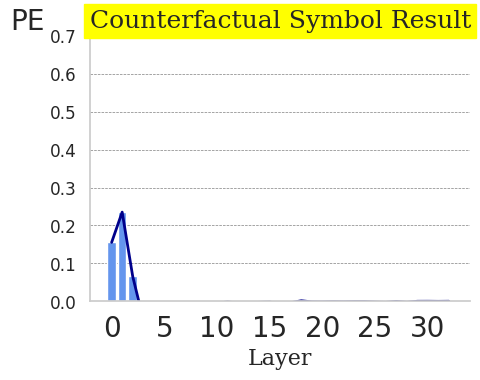

In [131]:
import matplotlib.patches as patches
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# Match the style settings from your heatmap
sns.set(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid': False})
row_7 = df.iloc[6]  # Get the 7th row of the dataframe

# Create the bar plot with a figure size and color scheme to match the heatmap
plt.figure(figsize=(5, 4))
bars = plt.bar(range(len(row_7)), row_7, color='CornflowerBlue', label='Patching Effect')

# Add a line plot to connect the bars, using a darker shade for contrast
plt.plot(range(len(row_7)), row_7, color='darkblue', marker='', linestyle='-', linewidth=2, markersize=8)

# Set the x-axis and y-axis labels with font settings to match the heatmap
plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('PE', rotation=0, loc="top", fontsize=20)  # Removing y-axis title as per heatmap adjustments

# Adjust tick labels to match the heatmap's style and rotation
# Customizing x-ticks to show only every 5th tick
tick_positions = range(0, len(row_7), 5)  # Generate tick positions starting from 0, stepping by 5
tick_labels = [str(i) for i in tick_positions]  # Generate tick labels corresponding to the positions
plt.xticks(tick_positions, tick_labels, fontsize=20, rotation=0)  # Apply custom ticks and labels
# tick_pos_y = range(0, 2)
# tick_labels_y = [str(i) for i in tick_pos_y]
# plt.yticks(tick_pos_y, tick_labels_y, fontsize=20)
#plt.yticks(fontsize=20)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='grey')
plt.ylim(0, .7)


title_text = plt.title('Counterfactual Symbol Result', fontsize=18, fontname='DeJavu Serif', backgroundcolor='yellow')  # Attempt to set background, mainly for text object dimensions

# Attempt to directly set the background color of the title (not effective for the background)
# Since matplotlib doesn't support background color for titles directly, we use a workaround

# Draw a rectangle behind the title for the yellow background
# Note: You might need to adjust the coordinates and size based on your figure's layout and title size
title_bbox = title_text.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
#title_bbox = title_bbox.inverse_transformed(plt.gca().transAxes)
pad = 0.05  # Padding around the title
rect = patches.Rectangle((title_bbox.x0 - pad, title_bbox.y0 - pad*0.5), 
                         width=title_bbox.width + pad*2, 
                         height=title_bbox.height + pad, 
                         transform=plt.gca().transAxes,  
                         color='yellow',
                         zorder=-1)
plt.gca().add_patch(rect)

sns.despine()
plt.tight_layout()
plt.show()


In [119]:
for i in range(0,2):
    print(i)

0
1


In [120]:
row_7

0     0.270950
1     0.335457
2     0.066777
3    -0.036226
4    -0.008205
5    -0.009777
6    -0.004103
7    -0.002270
8    -0.007769
9    -0.004190
10   -0.003666
11   -0.006198
12   -0.005761
13   -0.004103
14   -0.003492
15   -0.001135
16   -0.006896
17   -0.001920
18   -0.002182
19   -0.001047
20   -0.004103
21   -0.002531
22   -0.002706
23   -0.001309
24   -0.000873
25   -0.000873
26   -0.002968
27   -0.001397
28   -0.000436
29   -0.003055
30   -0.000524
31   -0.000960
32    0.000000
Name: Result, dtype: float64

In [64]:
row_0 = df.iloc[0] 
row_0

0     0.325004
1    -0.119501
2    -0.002706
3    -0.030028
4    -0.003142
5    -0.003055
6     0.002357
7    -0.004015
8    -0.004277
9    -0.003666
10   -0.003841
11   -0.002357
12   -0.002706
13   -0.002357
14   -0.000349
15    0.000087
16   -0.005412
17   -0.002793
18    0.000175
19   -0.000262
20   -0.002793
21   -0.002008
22   -0.001397
23   -0.000349
24   -0.002531
25   -0.000087
26    0.001397
27   -0.000611
28   -0.000960
29   -0.000960
30   -0.001659
31   -0.000436
32    0.000000
Name: 1st operand, dtype: float64

In [30]:
row_2 = df.iloc[2]
row_2

0     0.141101
1    -0.019658
2     0.010290
3    -0.010702
4    -0.008067
5    -0.010702
6    -0.002541
7    -0.000762
8    -0.001397
9     0.002954
10   -0.006701
11   -0.018261
12   -0.006764
13    0.014228
14    0.003525
15    0.004351
16    0.006288
17   -0.001239
18   -0.003017
19    0.006828
20    0.012354
21    0.014355
22    0.005558
23    0.024168
24    0.008829
25    0.020008
26    0.009019
27    0.017213
28    0.017562
29    0.012640
30    0.014831
31    0.015625
32    0.014704
33    0.015307
34    0.015339
35    0.015657
Name: 2nd operand, dtype: float64

In [31]:
row_4 = df.iloc[4]
row_4

0     0.137830
1    -0.002922
2    -0.017181
3    -0.010417
4    -0.004002
5    -0.001207
6     0.000349
7     0.003970
8    -0.006225
9    -0.000953
10   -0.014990
11   -0.015816
12    0.013053
13    0.002985
14    0.000222
15   -0.003779
16    0.012671
17    0.012703
18    0.002445
19    0.007527
20    0.000953
21    0.022072
22    0.007527
23    0.010893
24    0.005971
25    0.010353
26    0.020643
27    0.011306
28    0.013561
29    0.014196
30    0.016832
31    0.015847
32    0.014609
33    0.015149
34    0.015466
35    0.015657
Name: 3rd operand, dtype: float64

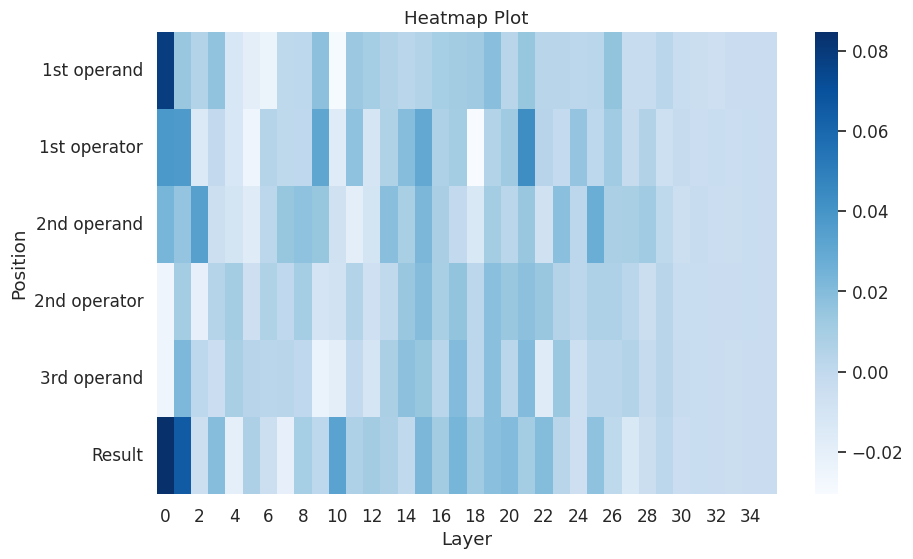

In [32]:
# 6 x layer matrix
matrix = np.empty((6, len(data['layer'].unique())))
for i, op in enumerate(['position_first_operand', 'position_first_operator', 'position_second_operand', 'position_second_operator', 'position_third_operand', 'position_result']):
    for j, layer in enumerate(data['layer'].unique()):
        subset_df = data[(data[op] == data['position']) & (data['representation'] == 'words')]
        subset_df = subset_df[subset_df['layer'] == layer]
        matrix[i, j] = subset_df['patching_effect'].mean()
# Create a dataframe from the matrix
df = pd.DataFrame(matrix, index=['1st operand', '1st operator', '2nd operand', '2nd operator', '3rd operand', 'Result'], columns=data['layer'].unique())

# Create the heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap='Blues', annot=False, fmt=".2f", cbar=True)
plt.xlabel('Layer')
plt.ylabel('Position')
plt.title('Heatmap Plot')
plt.show()



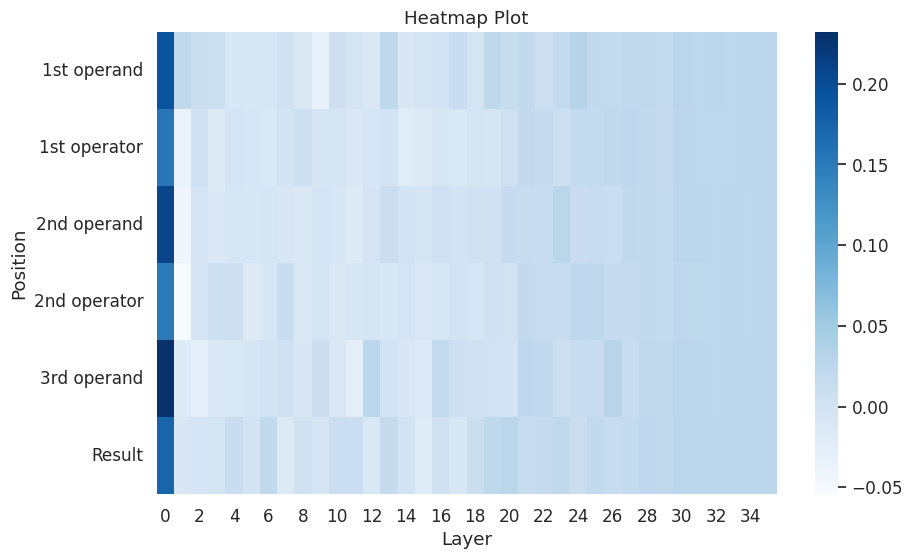

In [33]:
# 6 x layer matrix
matrix = np.empty((6, len(data['layer'].unique())))
for i, op in enumerate(['position_first_operand', 'position_first_operator', 'position_second_operand', 'position_second_operator', 'position_third_operand', 'position_result']):
    for j, layer in enumerate(data['layer'].unique()):
        subset_df = data[(data[op] == data['position']) & (data['representation'] == 'arabic')]
        subset_df = subset_df[subset_df['layer'] == layer]
        matrix[i, j] = subset_df['patching_effect'].mean()
# Create a dataframe from the matrix
df = pd.DataFrame(matrix, index=['1st operand', '1st operator', '2nd operand', '2nd operator', '3rd operand', 'Result'], columns=data['layer'].unique())

# Create the heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap='Blues', annot=False, fmt=".2f", cbar=True)
plt.xlabel('Layer')
plt.ylabel('Position')
plt.title('Heatmap Plot')
plt.show()

In [34]:
# first_few_shots = data.groupby('operation')['few_shots'].first()
# first_few_shots = first_few_shots.reset_index()
# first_few_shots['few_shot_string'] = first_few_shots['few_shots'].apply(lambda x: x.split())
# def split_on_special_characters(lst):
#     # Define the regular expression pattern
#     pattern = r'(\w+)([!,:?])'
#     # Initialize an empty list to store the results
#     result = []
#     for item in lst:
#         # Find all matches in the string
#         matches = re.findall(pattern, item)
#         if matches:
#             # If matches are found, extend the result list with the split elements
#             for match in matches:
#                 result.extend(match)
#         else:
#             # If no matches, just append the item as it is
#             result.append(item)
#     return result
# # Apply the function to the 'few_shot_string' column
# first_few_shots['few_shot_string'] = first_few_shots['few_shot_string'].apply(split_on_special_characters)
# unique_examples_by_operation = data.groupby('operation')['example'].nunique()
# first_few_shots['n_instances'] = first_few_shots['operation'].map(unique_examples_by_operation)
# print(first_few_shots)
# # Group the data by operation
# grouped_data = data.groupby('operation')
# fig, axes = plt.subplots(len(grouped_data), 1, figsize=(10, 4 * len(grouped_data)))
# for i, (operation, group) in enumerate(grouped_data):
#     few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
#     mean_IE_by_position_operation = group.groupby('position')['patching_effect_normalized'].mean()
#     ax = axes[i] if len(grouped_data) > 1 else axes
#     mean_IE_by_position_operation.plot(kind='bar', xlabel='Position', ylabel='Mean Patching Effect norm', ax=ax)
#     ax.set_title(f'Mean Normalized Patching Effect for {few_shot_string} (N={first_few_shots[first_few_shots["operation"] == operation]["n_instances"].values[0]})')
#     ax.set_xticks(ticks=range(len(few_shot_string)), labels=few_shot_string)
#     ax.legend([operation])
# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(len(grouped_data), 1, figsize=(10, 4 * len(grouped_data)))
# for i,  (operation, group) in enumerate(grouped_data):
#     few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
#     # inspect the position with the highest mean IE except for the last position
#     mean_IE_by_position_operation = group.groupby('position')['patching_effect_normalized'].mean()
#     last_position = mean_IE_by_position_operation.index[-1]
#     # remove the last position from mean_IE_by_position_operation
#     mean_IE_by_position_operation = mean_IE_by_position_operation.drop(last_position)
#     # get the positon with the highest mean IE
#     highest_mean_IE_position = mean_IE_by_position_operation.idxmax()
#     mean_IE_highest_position_operation = group[group['position'] == highest_mean_IE_position].groupby('layer')['patching_effect_normalized'].mean()
#     #mean_IE_highest_position_operation.plot(x='layer', y='IE', kind='bar', xlabel='Layer', ylabel='Mean IE', title=f'Mean IE logits for {few_shot_string} at pos {highest_mean_IE_position}')
#     ax = axes[i] if len(grouped_data) > 1 else axes
#     mean_IE_highest_position_operation.plot(kind='bar', xlabel='Layer', ylabel='Mean Patching Effect norm', ax=ax)
#     ax.set_title(f'Mean Normalized Patching Effect for {few_shot_string} at Position {highest_mean_IE_position} (N={first_few_shots[first_few_shots["operation"] == operation]["n_instances"].values[0]})')
#     # set the xticks to the range of unique layers
#     ax.set_xticks(ticks=range(len(group['layer'].unique())))
#     ax.legend([operation])
# plt.tight_layout()
# plt.show()
# fig, axes = plt.subplots(len(grouped_data), 1, figsize=(10, 4 * len(grouped_data)))
# for i,  (operation, group) in enumerate(grouped_data):
#     few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
#     # inspect the result position mean IE
#     mean_IE_by_position_operation = group.groupby('position')['patching_effect_normalized'].mean()
#     last_position = len(few_shot_string) - 1
#     # group the data by the last position
#     mean_IE_by_position_operation = group[group['position'] == last_position].groupby('layer')['patching_effect_normalized'].mean()
#     ax = axes[i] if len(grouped_data) > 1 else axes
#     mean_IE_by_position_operation.plot(kind='bar', xlabel='Layer', ylabel='Mean Patching Effect norm', ax=ax)
#     ax.set_title(f'Mean Normalized Patching Effect for {few_shot_string} at Position {last_position} (N={first_few_shots[first_few_shots["operation"] == operation]["n_instances"].values[0]})')
#     # set the xticks to the range of unique layers
#     ax.set_xticks(ticks=range(len(group['layer'].unique())))
#     ax.legend([operation])
# plt.tight_layout()
# plt.show()